In [ ]:
# %% [markdown]
# # 🍊 Pelatihan Klasifikasi Citra Jeruk dengan EfficientNetV2-L (Optimized & Checkpointed)
# 
# ## Sel 1: Setup - Import, Wrapper, dan Fungsi Training
# ---

# %%
# region Sel 1: Import, Wrapper, dan Definisi Fungsi
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Subset, WeightedRandomSampler
from torchvision import datasets, models, transforms
from torchvision.models import EfficientNet_V2_L_Weights
from torch.utils.checkpoint import checkpoint
import matplotlib.pyplot as plt
import time
import copy
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sys
import warnings

warnings.filterwarnings("ignore", ".*is still alive.*")

class CheckpointWrapper(nn.Module): # 8 GEBEH
    def __init__(self, module):
        super().__init__()
        self.module = module
    def forward(self, x):
        return checkpoint(self.module, x, use_reentrant=False)

class TransformedSubset(torch.utils.data.Dataset): # 
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

def train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs, dataset_sizes, phase_name="Training", scaler=None): 
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"\n--- Memulai {phase_name} (Epochs: {num_epochs}, AMP: {'Aktif' if scaler else 'Nonaktif'}) ---")

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0
            dataloader = dataloaders[phase]
            pbar = tqdm(dataloader, desc=f"{phase.capitalize()} Epoch {epoch+1}", leave=False)

            for inputs, labels in pbar:
                try:
                    inputs, labels = inputs.to(device), labels.to(device)
                except Exception as e:
                    print(f"\nError memindahkan data ke {device}: {e}", file=sys.stderr)
                    continue

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'), torch.autocast(device_type=device.type, dtype=torch.float16, enabled=(device.type == 'cuda' and scaler is not None)): 
                    try:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    except Exception as e:
                         print(f"\nError during forward pass (Autocast): {e}", file=sys.stderr)
                         if "CUDA out of memory" in str(e):
                             print(" (!) CUDA out of memory. Coba kurangi BATCH_SIZE_TUNE.", file=sys.stderr)
                         continue

                if phase == 'train':
                    if scaler:
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{torch.sum(preds == labels.data)/inputs.size(0):.4f}'})

            if dataset_sizes[phase] == 0:
                 epoch_loss, epoch_acc = 0.0, 0.0
            else:
                 epoch_loss = running_loss / dataset_sizes[phase]
                 epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"  {phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f"    -> Akurasi validasi terbaik baru: {best_acc:.4f}. Menyimpan model sementara...")
                    torch.save(model.state_dict(), f'best_model_{phase_name.replace(" ", "_").lower()}_temp.pth')
        
        if scheduler:
            scheduler.step()
            print(f"  LR disetel ke: {scheduler.get_last_lr()[0]:.1e}")

        print("-" * 10)

    time_elapsed = time.time() - since
    print(f"{phase_name} selesai dalam {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Akurasi Validasi Terbaik: {best_acc:.4f}")
    
    print("Memuat bobot model terbaik...")
    try:
        model.load_state_dict(best_model_wts)
    except Exception as e:
        print(f"Error loading best model weights: {e}", file=sys.stderr)
    return model, history
# endregion

In [ ]:
# %% [markdown]
# ## Sel 2: Konfigurasi Parameter dan Persiapan Data (Final Revision)
# ---

# %%
# region Sel 2: Konfigurasi dan Persiapan Data
DATASET_PATH = 'Dataset'
IMG_SIZE = 224
BATCH_SIZE_EXTRACT = 64
BATCH_SIZE_TUNE = 6
    
EPOCHS_FEATURE_EXTRACT = 10
EPOCHS_FINE_TUNE = 20
    
VALIDATION_SPLIT = 0.2 # 20%/80% Train/Val
LR_FEATURE_EXTRACT = 1e-2
LR_FINE_TUNE = 1e-3
    
WEIGHT_DECAY = 1e-2
LABEL_SMOOTHING = 0.1
    
PLOT_FILENAME = 'training_results_optimized.png'
CONFUSION_MATRIX_FILENAME = 'confusion_matrix_optimized.png'
BEST_MODEL_EXTRACT_PATH = 'best_model_extract_optimized.pth'
MODEL_SAVE_PATH = 'citrus_efficientnetv2l_pytorch_final_checkpointed_optimized.pth'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Menggunakan Device: {device}")

print("Mempersiapkan transformasi data (Augmentasi Dihapus)...")
weights = EfficientNet_V2_L_Weights.DEFAULT
preprocess = weights.transforms(antialias=True)

train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    preprocess
])

val_transforms = preprocess

try:
    full_dataset = datasets.ImageFolder(DATASET_PATH, transform=None)
    CLASSES = sorted(full_dataset.classes)
    NUM_CLASSES = len(CLASSES)
    print(f"Total gambar: {len(full_dataset)}. Kelas: {NUM_CLASSES}")

    class_counts_dict = {full_dataset.classes[i]: count for i, count in enumerate(np.bincount(full_dataset.targets))}
    counts = list(class_counts_dict.values())
    is_imbalanced = min(counts) > 0 and (max(counts) / min(counts)) > 2.0 if counts else False
    if is_imbalanced:
         print(f"(!) Imbalanced data terdeteksi ({class_counts_dict}). Mengaktifkan WeightedRandomSampler.")

    class_weights = [len(full_dataset) / class_counts_dict[full_dataset.classes[i]] for i in range(NUM_CLASSES)]
    
    total_len = len(full_dataset)
    val_len = int(total_len * VALIDATION_SPLIT)
    train_len = total_len - val_len

    generator = torch.Generator().manual_seed(42)
    train_indices, val_indices = random_split(range(total_len), [train_len, val_len], generator=generator)

    original_train_subset = Subset(full_dataset, train_indices)
    
    train_sampler = None
    shuffle_train = True
    if is_imbalanced and train_len > 0:
        train_sample_weights = [class_weights[full_dataset.targets[i]] for i in original_train_subset.indices]
        train_sampler = torch.utils.data.WeightedRandomSampler(
            weights=torch.DoubleTensor(train_sample_weights),
            num_samples=train_len,
            replacement=True
        )
        shuffle_train = False

    train_dataset = TransformedSubset(original_train_subset, train_transforms)
    val_dataset = TransformedSubset(Subset(full_dataset, val_indices), val_transforms)

    num_workers = 0 
    persistent = False
    print(f"Menggunakan num_workers={num_workers} (Solusi Deadlock).")
    
    pin_memory = torch.cuda.is_available()

    dataloaders_extract = {
        'train': DataLoader(train_dataset, batch_size=BATCH_SIZE_EXTRACT, sampler=train_sampler, shuffle=shuffle_train, num_workers=num_workers, pin_memory=pin_memory, persistent_workers=persistent),
        'val': DataLoader(val_dataset, batch_size=BATCH_SIZE_EXTRACT, shuffle=False, num_workers=num_workers, pin_memory=pin_memory, persistent_workers=persistent)
    }
    dataloaders_tune = {
        'train': DataLoader(train_dataset, batch_size=BATCH_SIZE_TUNE, sampler=train_sampler, shuffle=shuffle_train, num_workers=num_workers, pin_memory=pin_memory, persistent_workers=persistent),
        'val': DataLoader(val_dataset, batch_size=BATCH_SIZE_TUNE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory, persistent_workers=persistent)
    }

    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
    class_names = CLASSES
    print("Dataset dan Dataloader siap.")

except Exception as e:
    print(f"Error saat memuat data: {e}", file=sys.stderr)
    sys.exit(1)
# endregion

Menggunakan Device: cuda
Mempersiapkan transformasi data (Augmentasi Dihapus)...
Total gambar: 38432. Kelas: 5
(!) Imbalanced data terdeteksi ({'Citrus_Canker_Diseases_Leaf_Orange': np.int64(11248), 'Citrus_Nutrient_Deficiency_Yellow_Leaf_Orange': np.int64(12800), 'Healthy_Leaf_Orange': np.int64(6384), 'Multiple_Diseases_Leaf_Orange': np.int64(4800), 'Young_Healthy_Leaf_Orange': np.int64(3200)}). Mengaktifkan WeightedRandomSampler.
Menggunakan num_workers=0 (Solusi Deadlock).
Dataset dan Dataloader siap.


In [4]:
# %% [markdown]
# ## Sel 3: Tahap 1: Feature Extraction
# ---

# %%
# region Sel 3: Feature Extraction
print("\n=== TAHAP 1: FEATURE EXTRACTION (DENGAN AMP) ===")
model_extract = models.efficientnet_v2_l(weights=weights)

print("(!) Menerapkan Gradient Checkpointing...")
for i, block_sequence in enumerate(model_extract.features):
    if isinstance(block_sequence, nn.Sequential):
        model_extract.features[i] = CheckpointWrapper(block_sequence)

print("Membekukan bobot base model...")
for param in model_extract.features.parameters():
    param.requires_grad = False

num_ftrs = model_extract.classifier[1].in_features
model_extract.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(num_ftrs, NUM_CLASSES)
)
model_extract = model_extract.to(device)

criterion_extract = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer_extract = optim.AdamW(model_extract.classifier.parameters(), lr=LR_FEATURE_EXTRACT, weight_decay=WEIGHT_DECAY)
scheduler_extract = optim.lr_scheduler.CosineAnnealingLR(optimizer_extract, T_max=EPOCHS_FEATURE_EXTRACT)

# Sintaks diperbarui untuk PyTorch versi yang lebih baru
scaler_extract = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None

model_extract, history_extract = train_model(
    model=model_extract,
    criterion=criterion_extract,
    optimizer=optimizer_extract,
    scheduler=scheduler_extract, 
    dataloaders=dataloaders_extract,
    device=device,
    num_epochs=EPOCHS_FEATURE_EXTRACT,
    dataset_sizes=dataset_sizes,
    phase_name="Feature Extraction",
    scaler=scaler_extract
)

torch.save(model_extract.state_dict(), BEST_MODEL_EXTRACT_PATH)
print(f"Model Feature Extraction disimpan sebagai {BEST_MODEL_EXTRACT_PATH}")
# endregion


=== TAHAP 1: FEATURE EXTRACTION (DENGAN AMP) ===
(!) Menerapkan Gradient Checkpointing...
Membekukan bobot base model...

--- Memulai Feature Extraction (Epochs: 10, AMP: Aktif) ---
Epoch 1/10


Train Epoch 1:   0%|          | 0/481 [00:00<?, ?it/s]

  Train Loss: 0.8134 Acc: 0.8518


Val Epoch 1:   0%|          | 0/121 [00:00<?, ?it/s]

  Val Loss: 0.6583 Acc: 0.9346
    -> Akurasi validasi terbaik baru: 0.9346. Menyimpan model sementara...
  LR disetel ke: 9.8e-03
----------
Epoch 2/10


Train Epoch 2:   0%|          | 0/481 [00:00<?, ?it/s]

  Train Loss: 0.8418 Acc: 0.8606


Val Epoch 2:   0%|          | 0/121 [00:00<?, ?it/s]

  Val Loss: 0.7373 Acc: 0.9339
  LR disetel ke: 9.0e-03
----------
Epoch 3/10


Train Epoch 3:   0%|          | 0/481 [00:00<?, ?it/s]

  Train Loss: 0.8341 Acc: 0.8624


Val Epoch 3:   0%|          | 0/121 [00:00<?, ?it/s]

  Val Loss: 0.7678 Acc: 0.9195
  LR disetel ke: 7.9e-03
----------
Epoch 4/10


Train Epoch 4:   0%|          | 0/481 [00:00<?, ?it/s]

  Train Loss: 0.8053 Acc: 0.8683


Val Epoch 4:   0%|          | 0/121 [00:00<?, ?it/s]

  Val Loss: 0.6999 Acc: 0.9118
  LR disetel ke: 6.5e-03
----------
Epoch 5/10


Train Epoch 5:   0%|          | 0/481 [00:00<?, ?it/s]

  Train Loss: 0.7406 Acc: 0.8810


Val Epoch 5:   0%|          | 0/121 [00:00<?, ?it/s]

  Val Loss: 0.6397 Acc: 0.9257
  LR disetel ke: 5.0e-03
----------
Epoch 6/10


Train Epoch 6:   0%|          | 0/481 [00:00<?, ?it/s]

  Train Loss: 0.7044 Acc: 0.8917


Val Epoch 6:   0%|          | 0/121 [00:00<?, ?it/s]

  Val Loss: 0.5935 Acc: 0.9468
    -> Akurasi validasi terbaik baru: 0.9468. Menyimpan model sementara...
  LR disetel ke: 3.5e-03
----------
Epoch 7/10


Train Epoch 7:   0%|          | 0/481 [00:00<?, ?it/s]

  Train Loss: 0.6706 Acc: 0.9025


Val Epoch 7:   0%|          | 0/121 [00:00<?, ?it/s]

  Val Loss: 0.5665 Acc: 0.9585
    -> Akurasi validasi terbaik baru: 0.9585. Menyimpan model sementara...
  LR disetel ke: 2.1e-03
----------
Epoch 8/10


Train Epoch 8:   0%|          | 0/481 [00:00<?, ?it/s]

  Train Loss: 0.6354 Acc: 0.9166


Val Epoch 8:   0%|          | 0/121 [00:00<?, ?it/s]

  Val Loss: 0.5396 Acc: 0.9662
    -> Akurasi validasi terbaik baru: 0.9662. Menyimpan model sementara...
  LR disetel ke: 9.5e-04
----------
Epoch 9/10


Train Epoch 9:   0%|          | 0/481 [00:00<?, ?it/s]

  Train Loss: 0.6124 Acc: 0.9273


Val Epoch 9:   0%|          | 0/121 [00:00<?, ?it/s]

  Val Loss: 0.5354 Acc: 0.9679
    -> Akurasi validasi terbaik baru: 0.9679. Menyimpan model sementara...
  LR disetel ke: 2.4e-04
----------
Epoch 10/10


Train Epoch 10:   0%|          | 0/481 [00:00<?, ?it/s]

  Train Loss: 0.6027 Acc: 0.9309


Val Epoch 10:   0%|          | 0/121 [00:00<?, ?it/s]

  Val Loss: 0.5283 Acc: 0.9681
    -> Akurasi validasi terbaik baru: 0.9681. Menyimpan model sementara...
  LR disetel ke: 0.0e+00
----------
Feature Extraction selesai dalam 98m 16s
Akurasi Validasi Terbaik: 0.9681
Memuat bobot model terbaik...
Model Feature Extraction disimpan sebagai best_model_extract_optimized.pth


In [5]:
# %% [markdown]
# ## Sel 4: Tahap 2: Fine-Tuning
# ---

# %%
# region Sel 4: Fine-Tuning
print("\n=== TAHAP 2: FINE-TUNING (DENGAN AMP) ===")
model_tune = models.efficientnet_v2_l(weights=None) 
num_ftrs_tune = model_tune.classifier[1].in_features
model_tune.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(num_ftrs_tune, NUM_CLASSES)
)

print("(!) Menerapkan Gradient Checkpointing untuk Fine-Tuning...")
for i, block_sequence in enumerate(model_tune.features):
    if isinstance(block_sequence, nn.Sequential):
        model_tune.features[i] = CheckpointWrapper(block_sequence)

try:
    print(f"Mencoba memuat bobot dari: {BEST_MODEL_EXTRACT_PATH}")
    model_tune.load_state_dict(torch.load(BEST_MODEL_EXTRACT_PATH, map_location=torch.device('cpu')))
    print("Bobot terbaik dimuat.")
except Exception as e:
    print(f"Error saat memuat bobot: {e}. Menggunakan state dari model_extract.", file=sys.stderr)
    model_tune.load_state_dict(model_extract.state_dict() if 'model_extract' in locals() else torch.load(f'best_model_feature_extraction_temp.pth', map_location=torch.device('cpu')))

print("Membuka semua bobot model...")
for param in model_tune.parameters():
    param.requires_grad = True

model_tune = model_tune.to(device)

criterion_tune = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer_tune = optim.AdamW(model_tune.parameters(), lr=LR_FINE_TUNE, weight_decay=WEIGHT_DECAY)
scheduler_tune = optim.lr_scheduler.CosineAnnealingLR(optimizer_tune, T_max=EPOCHS_FINE_TUNE)

# Sintaks diperbarui untuk PyTorch versi yang lebih baru
scaler_tune = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None

model_final, history_tune = train_model(
    model=model_tune,
    criterion=criterion_tune,
    optimizer=optimizer_tune,
    scheduler=scheduler_tune, 
    dataloaders=dataloaders_tune,
    device=device,
    num_epochs=EPOCHS_FINE_TUNE,
    dataset_sizes=dataset_sizes,
    phase_name="Fine-Tuning",
    scaler=scaler_tune
)

combined_history = {}
if 'history_extract' in locals():
    combined_history['train_loss'] = history_extract.get('train_loss', []) + history_tune.get('train_loss', [])
    combined_history['train_acc'] = history_extract.get('train_acc', []) + history_tune.get('train_acc', [])
    combined_history['val_loss'] = history_extract.get('val_loss', []) + history_tune.get('val_loss', [])
    combined_history['val_acc'] = history_extract.get('val_acc', []) + history_tune.get('val_acc', [])

torch.save(model_final.state_dict(), MODEL_SAVE_PATH)
print(f"Model final disimpan sebagai {MODEL_SAVE_PATH}")
# endregion


=== TAHAP 2: FINE-TUNING (DENGAN AMP) ===
(!) Menerapkan Gradient Checkpointing untuk Fine-Tuning...
Mencoba memuat bobot dari: best_model_extract_optimized.pth
Bobot terbaik dimuat.
Membuka semua bobot model...

--- Memulai Fine-Tuning (Epochs: 20, AMP: Aktif) ---
Epoch 1/20


Train Epoch 1:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.5833 Acc: 0.9228


Val Epoch 1:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.5843 Acc: 0.9041
    -> Akurasi validasi terbaik baru: 0.9041. Menyimpan model sementara...
  LR disetel ke: 9.9e-04
----------
Epoch 2/20


Train Epoch 2:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.4395 Acc: 0.9868


Val Epoch 2:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4593 Acc: 0.9729
    -> Akurasi validasi terbaik baru: 0.9729. Menyimpan model sementara...
  LR disetel ke: 9.8e-04
----------
Epoch 3/20


Train Epoch 3:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.4206 Acc: 0.9916


Val Epoch 3:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.5075 Acc: 0.9556
  LR disetel ke: 9.5e-04
----------
Epoch 4/20


Train Epoch 4:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.4090 Acc: 0.9953


Val Epoch 4:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4491 Acc: 0.9723
  LR disetel ke: 9.0e-04
----------
Epoch 5/20


Train Epoch 5:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.4084 Acc: 0.9949


Val Epoch 5:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4994 Acc: 0.9541
  LR disetel ke: 8.5e-04
----------
Epoch 6/20


Train Epoch 6:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.4043 Acc: 0.9964


Val Epoch 6:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4605 Acc: 0.9630
  LR disetel ke: 7.9e-04
----------
Epoch 7/20


Train Epoch 7:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.4015 Acc: 0.9968


Val Epoch 7:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4327 Acc: 0.9796
    -> Akurasi validasi terbaik baru: 0.9796. Menyimpan model sementara...
  LR disetel ke: 7.3e-04
----------
Epoch 8/20


Train Epoch 8:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.3984 Acc: 0.9980


Val Epoch 8:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4205 Acc: 0.9861
    -> Akurasi validasi terbaik baru: 0.9861. Menyimpan model sementara...
  LR disetel ke: 6.5e-04
----------
Epoch 9/20


Train Epoch 9:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.3971 Acc: 0.9982


Val Epoch 9:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4926 Acc: 0.9533
  LR disetel ke: 5.8e-04
----------
Epoch 10/20


Train Epoch 10:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.3940 Acc: 0.9994


Val Epoch 10:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4168 Acc: 0.9909
    -> Akurasi validasi terbaik baru: 0.9909. Menyimpan model sementara...
  LR disetel ke: 5.0e-04
----------
Epoch 11/20


Train Epoch 11:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.3941 Acc: 0.9991


Val Epoch 11:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4177 Acc: 0.9887
  LR disetel ke: 4.2e-04
----------
Epoch 12/20


Train Epoch 12:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.3935 Acc: 0.9992


Val Epoch 12:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4165 Acc: 0.9880
  LR disetel ke: 3.5e-04
----------
Epoch 13/20


Train Epoch 13:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.3929 Acc: 0.9993


Val Epoch 13:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4495 Acc: 0.9705
  LR disetel ke: 2.7e-04
----------
Epoch 14/20


Train Epoch 14:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.3920 Acc: 0.9996


Val Epoch 14:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4200 Acc: 0.9866
  LR disetel ke: 2.1e-04
----------
Epoch 15/20


Train Epoch 15:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.3908 Acc: 1.0000


Val Epoch 15:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4174 Acc: 0.9895
  LR disetel ke: 1.5e-04
----------
Epoch 16/20


Train Epoch 16:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.3906 Acc: 1.0000


Val Epoch 16:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4169 Acc: 0.9891
  LR disetel ke: 9.5e-05
----------
Epoch 17/20


Train Epoch 17:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.3905 Acc: 1.0000


Val Epoch 17:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4152 Acc: 0.9897
  LR disetel ke: 5.4e-05
----------
Epoch 18/20


Train Epoch 18:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.3904 Acc: 1.0000


Val Epoch 18:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4059 Acc: 0.9928
    -> Akurasi validasi terbaik baru: 0.9928. Menyimpan model sementara...
  LR disetel ke: 2.4e-05
----------
Epoch 19/20


Train Epoch 19:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.3903 Acc: 1.0000


Val Epoch 19:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4102 Acc: 0.9914
  LR disetel ke: 6.2e-06
----------
Epoch 20/20


Train Epoch 20:   0%|          | 0/5125 [00:00<?, ?it/s]

  Train Loss: 0.3903 Acc: 1.0000


Val Epoch 20:   0%|          | 0/1281 [00:00<?, ?it/s]

  Val Loss: 0.4095 Acc: 0.9917
  LR disetel ke: 0.0e+00
----------
Fine-Tuning selesai dalam 664m 16s
Akurasi Validasi Terbaik: 0.9928
Memuat bobot model terbaik...
Model final disimpan sebagai citrus_efficientnetv2l_pytorch_final_checkpointed_optimized.pth



Membuat plot hasil training (training_results_optimized.png)...


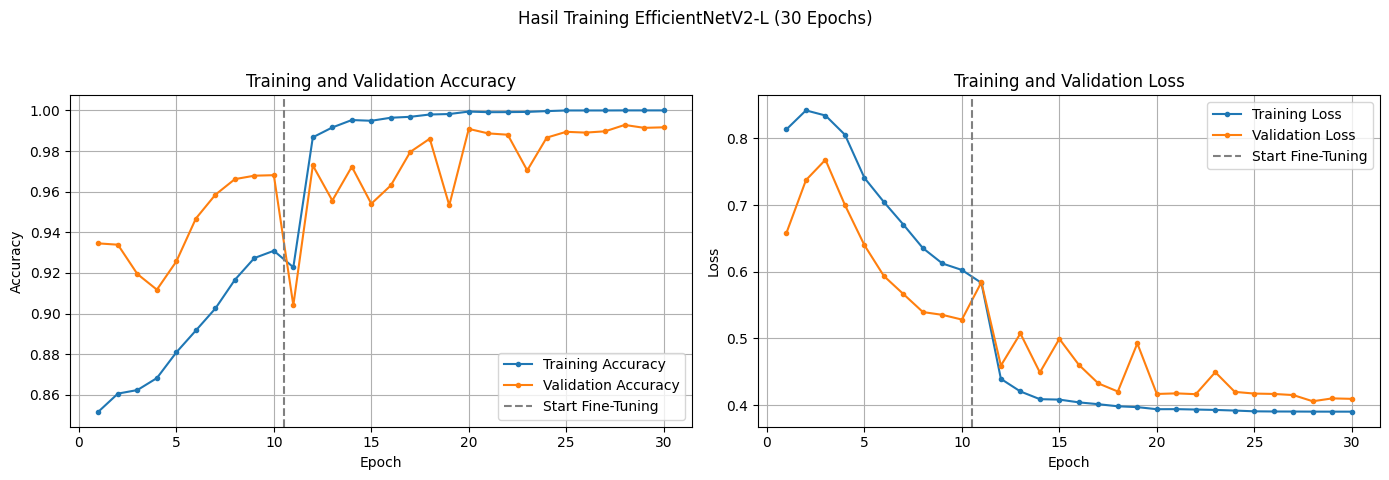

Plot disimpan sebagai training_results_optimized.png

Membuat Confusion Matrix (confusion_matrix_optimized.png)...


Evaluasi Validasi:   0%|          | 0/1281 [00:00<?, ?it/s]

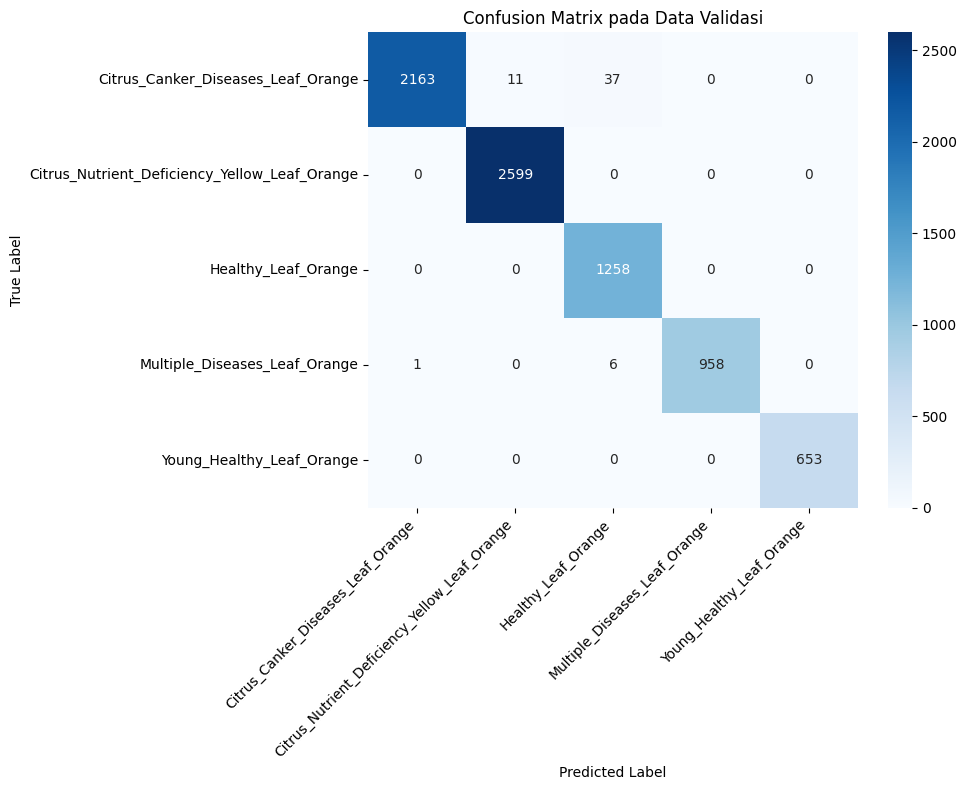

Confusion Matrix disimpan sebagai confusion_matrix_optimized.png

--- Selesai ---


In [6]:
# %% [markdown]
# ## Sel 5: Visualisasi dan Evaluasi Hasil
# ---

# %%
# region Sel 5: Visualisasi dan Evaluasi
print(f"\nMembuat plot hasil training ({PLOT_FILENAME})...")
if combined_history and combined_history.get('train_acc'):
    acc = combined_history['train_acc']
    val_acc = combined_history['val_acc']
    loss = combined_history['train_loss']
    val_loss = combined_history['val_loss']
    total_epochs_recorded = len(acc)
    epochs_range = range(1, total_epochs_recorded + 1)
    
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='.', linestyle='-')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='.', linestyle='-')
    if 'history_extract' in locals() and history_extract.get('train_acc'):
         plt.axvline(len(history_extract['train_acc']) + 0.5, color='grey', linestyle='--', label='Start Fine-Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='.', linestyle='-')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='.', linestyle='-')
    if 'history_extract' in locals() and history_extract.get('train_acc'):
         plt.axvline(len(history_extract['train_acc']) + 0.5, color='grey', linestyle='--', label='Start Fine-Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.suptitle(f'Hasil Training EfficientNetV2-L ({total_epochs_recorded} Epochs)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(PLOT_FILENAME)
    plt.show()
    plt.close()
    print(f"Plot disimpan sebagai {PLOT_FILENAME}")
else:
    print("History tidak lengkap, plot tidak dibuat.")

print(f"\nMembuat Confusion Matrix ({CONFUSION_MATRIX_FILENAME})...")
if 'model_final' in locals() and isinstance(model_final, nn.Module):
     model_to_eval = model_final
     model_to_eval.eval()
     all_preds = []
     all_labels = []
     eval_dataloader = dataloaders_tune['val']

     with torch.no_grad():
         for inputs, labels in tqdm(eval_dataloader, desc="Evaluasi Validasi"):
             inputs, labels = inputs.to(device), labels.to(device)
             
             with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=(device.type == 'cuda')):
                outputs = model_to_eval(inputs)
                
             _, preds = torch.max(outputs, 1)
             all_preds.extend(preds.cpu().numpy())
             all_labels.extend(labels.cpu().numpy())

     cf_matrix = confusion_matrix(all_labels, all_preds)

     plt.figure(figsize=(10, 8))
     sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names)
     plt.xlabel('Predicted Label')
     plt.ylabel('True Label')
     plt.title('Confusion Matrix pada Data Validasi')
     plt.xticks(rotation=45, ha='right')
     plt.yticks(rotation=0)
     plt.tight_layout()
     plt.savefig(CONFUSION_MATRIX_FILENAME)
     plt.show()
     plt.close()
     print(f"Confusion Matrix disimpan sebagai {CONFUSION_MATRIX_FILENAME}")
else:
     print("Model final tidak ditemukan, evaluasi dilewati.")

print("\n--- Selesai ---")
# endregion